# Unsupervised Learning on Countries - PCA, K-means Clustering and API

Identifying the coutries that are highly in need of humanitarian aid is crucial for NGOs. This allows organizations to efficiently allocate their resources and focus their efforts on supplying the necessary basic amenities to their population. In this way, life conditions and overall development of can be improved which ultimately result in achieving their main objective of fighting poverty. 

This objective of this project is to identify those countries based on information about socio-economic and health factors. To that end, principal component analysis (PCA) is performed based on the provided data, and k-means clustering technique is employed in order to categorize the countries. The latter allows us to prioritize the countries based on these categories so that the NGOs can provide the necessary support efficiently.
For a better intrepretation of results, illustrative maps are generated showcasing the categories. The latter is achieved by means of geopandas and also by requesting the countries' coordinates to a public API.

<img src="./world_map.jpeg" width=600 height=350 />

## Table of Contents

* [1. Data Overview](#chapter1)
* [2. Principal Component Analysis (PCA)](#chapter2)
    * [2.1. Data pre-processing](#section_2_1)
    * [2.2. PCA](#section_2_2)
    * [2.3. Variance and Dimensionality Reduction](#section_2_3)
* [3. K-means Clustering](#chapter3)
    * [3.1. Elbow Method](#section_3_1)
    * [3.2. Silhouette Coefficient](#section_3_2)
    * [3.3. Clusters Computation](#section_3_3)
* [4. Visualization of Results](#chapter4)
    * [4.1. Geopandas](#section_4_1)
    * [4.2. API - Latitude and Longitude](#section_4_2)

## 1. Data Overview <a class="anchor" id="chapter1"></a>

We start by loading the necessary packages that we intend to use:

In [818]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

import geopandas

import re

import requests
import json

Next we load the two files containing the data and the features' description:

In [819]:
data_path = os.getcwd()

data = pd.read_csv(f'{data_path}/Country-data.csv')
data_fts = pd.read_csv(f'{data_path}/data-dictionary.csv')

Let's now take a look at our dataset we just loaded:

In [820]:
print(f'There are {data.shape[0]} countries and {data.shape[1]} features')

There are 167 countries and 10 features


In [821]:
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


As observed, we have 10 informative features for each country. We can look  at the description of these features for a better understanding:

In [822]:
for ft,des in data_fts.values:
    print(f'{ft}: \n{des}\n')

country: 
Name of the country

child_mort: 
Death of children under 5 years of age per 1000 live births

exports: 
Exports of goods and services per capita. Given as %age of the GDP per capita

health: 
Total health spending per capita. Given as %age of GDP per capita

imports: 
Imports of goods and services per capita. Given as %age of the GDP per capita

Income: 
Net income per person

Inflation: 
The measurement of the annual growth rate of the Total GDP

life_expec: 
The average number of years a new born child would live if the current mortality patterns are to remain the same

total_fer: 
The number of children that would be born to each woman if the current age-fertility rates remain the same.

gdpp: 
The GDP per capita. Calculated as the Total GDP divided by the total population.



The next step is to make sure there are no missing data:

In [823]:
data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

Fortunately, there are no missing values!

We now check if any of the provided samples is duplicated:

In [824]:
print(f'Duplicates have been found: {data.duplicated().any()}')
unique_count = len(data.loc[:,'country'].unique())
print(f'There are {unique_count} unique countries for {data.shape[0]} samples')

Duplicates have been found: False
There are 167 unique countries for 167 samples


Good news! We do not have duplicated data nor countries.

## 2. Principal Component Analysis (PCA) <a class="anchor" id="chapter2"></a>

Now we aim to perform principal component analysis (PCA). The latter allows to create highly informative features based on the provided original ones. Thus, PCA is used for dimensionality reduction of our data by making a selection considering these optimum descriptive components. In order to apply PCA, we first need to pre-process our data.

### 2.1. Data pre-processing  <a class="anchor" id="section_2_1"></a>

Let's first remove the countries' names as these are merely used for identification and thus have no influence: 

In [825]:
countries = data.loc[:,'country'].copy()
df_data = data.loc[:,data.columns != 'country'].copy()

It should be taken into account that our data involves different orders of magnitudes depending on which feauture we are looking at. This difference results in a wide scale range of weight values, which are devisive when training the model. The latter leads to poor performance and inapropiate learning, as the larger, and thus most-influential, weights will be affected by the input order of magnitude. In this way, instability and convergence problems arise. In order to address these issues, a standard normal distribution of input data is desired. For that end, we apply a standar scaler so that our input features have zero mean and unit variance.

In [826]:
scaler = StandardScaler()
data_scaled= scaler.fit_transform(df_data)

We now put it back in the form of a dataframe:

In [827]:
df_data_scaled= pd.DataFrame(data_scaled, columns=df_data.columns)

Let's check how it looks:

In [828]:
df_data_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


We can also check that indeed features have zero mean and unit variance now:

In [829]:
df_data_scaled.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02
mean,-3.722904e-17,2.127373e-16,5.504579e-16,2.765585e-16,-7.977650e-17,-1.063687e-17,3.696311e-16,3.044803e-16,5.850277e-17
std,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00
min,-8.871383e-01,-1.500192e+00,-1.827827e+00,-1.939940e+00,-8.603259e-01,-1.137852e+00,-4.337186e+00,-1.191250e+00,-6.968005e-01
25%,-7.466190e-01,-6.333367e-01,-6.922106e-01,-6.914785e-01,-7.174558e-01,-5.666409e-01,-5.927576e-01,-7.639023e-01,-6.366596e-01
50%,-4.717981e-01,-2.235279e-01,-1.810007e-01,-1.487432e-01,-3.738080e-01,-2.269504e-01,2.869576e-01,-3.564309e-01,-4.544309e-01
75%,5.926666e-01,3.747198e-01,6.515412e-01,4.913530e-01,2.942370e-01,2.816364e-01,7.042584e-01,6.175252e-01,5.942100e-02
max,4.221297e+00,5.813835e+00,4.047436e+00,5.266181e+00,5.611542e+00,9.129718e+00,1.380962e+00,3.009349e+00,5.036507e+00


### 2.2. PCA <a class="anchor" id="section_2_2"></a>

Let's now apply PCA to our scaled data:

In [830]:
pca = PCA()
data_PCA = pca.fit_transform(df_data_scaled)

We now assign names for every computed component and we look at the results we obtained:

In [831]:
pc_names = [f"PC{i+1}" for i in range(data_PCA.shape[1])]
data_PCA = pd.DataFrame(data_PCA, columns=pc_names)
data_PCA

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,-2.913025,0.095621,-0.718118,1.005255,-0.158310,-0.254597,0.383000,0.415076,-0.014148
1,0.429911,-0.588156,-0.333486,-1.161059,0.174677,0.084579,0.248919,-0.221042,0.173316
2,-0.285225,-0.455174,1.221505,-0.868115,0.156475,-0.401696,-0.087214,-0.184162,0.084037
3,-2.932423,1.695555,1.525044,0.839625,-0.273209,-0.547996,-0.440835,-0.355998,-0.091339
4,1.033576,0.136659,-0.225721,-0.847063,-0.193007,-0.206919,0.241978,-0.023681,0.094270
...,...,...,...,...,...,...,...,...,...
162,-0.820631,0.639570,-0.389923,-0.706595,-0.395748,0.009059,-0.098738,0.521886,-0.497803
163,-0.551036,-1.233886,3.101350,-0.115311,2.082581,0.097274,0.206735,-0.078805,-0.275735
164,0.498524,1.390744,-0.238526,-1.074098,1.176081,0.051607,-0.143627,-0.217590,-0.036522
165,-1.887451,-0.109453,1.109752,0.056257,0.618365,-0.540917,0.060256,0.089495,-0.096049


As observed nine components out of nine input features were computed. One should take into account that the new components are computed based on linear combinations (weighted sums) of the original features. We can also check these weights, known as loadings: 

In [832]:
loadings = pd.DataFrame(pca.components_.T, columns=pc_names, index=df_data_scaled.columns)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
child_mort,-0.419519,0.192884,-0.029544,0.370653,-0.168970,0.200628,-0.079489,-0.682743,0.327542
exports,0.283897,0.613163,0.144761,0.003091,0.057616,-0.059333,-0.707303,-0.014197,-0.123082
health,0.150838,-0.243087,-0.596632,0.461897,0.518000,0.007276,-0.249831,0.072497,0.113088
imports,0.161482,0.671821,-0.299927,-0.071907,0.255376,-0.030032,0.592190,-0.028946,0.099037
income,0.398441,0.022536,0.301548,0.392159,-0.247150,0.160347,0.095562,0.352624,0.612982
inflation,-0.193173,-0.008404,0.642520,0.150442,0.714869,0.066285,0.104633,-0.011538,-0.025236
life_expec,0.425839,-0.222707,0.113919,-0.203797,0.108220,-0.601127,0.018486,-0.504664,0.294040
total_fer,-0.403729,0.155233,0.019549,0.378304,-0.135262,-0.750689,0.028826,0.293353,-0.026336
gdpp,0.392645,-0.046022,0.122977,0.531995,-0.180167,0.016779,0.242998,-0.249696,-0.625646


The higher the weight, the more influence a feature will have on the component and thus the higher variation. Moreover, positive and negatives signs provide information about the direction of variation.

If we look for example at the first principal component PC1, we can see that the two most influential features are the child mortality and the life expectancy. However, these two features vary in opposite directions, that is, an increase in the child mortality is linked to a decrease in the life expectancy. In the same way, we can also see that higher fertility has also negative variation. The plot below clealy illustrates the magnitude and direction of the loadings. 

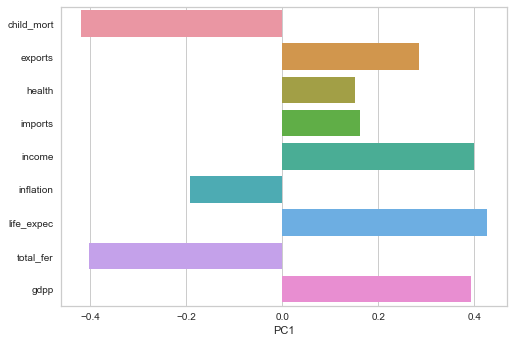

In [833]:
sns.barplot(data=loadings, x='PC1', y=loadings.index);

In the case of PC2, we can see that the inports and exports play an important role. As observed, these two magnitudes vary in the same direction with different magnitudes.

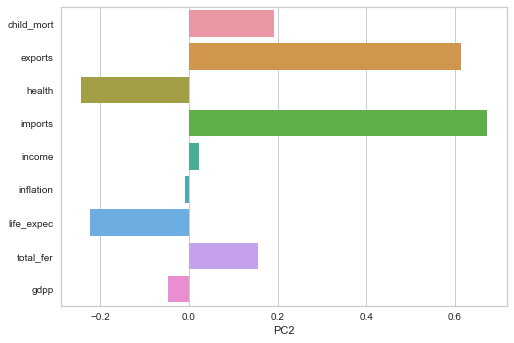

In [834]:
sns.barplot(data=loadings, x='PC2', y=loadings.index);

### 2.3. Variance and Dimensionality Reduction <a class="anchor" id="section_2_3"></a>

The variance represents the amount of information that can be attributed to each of the principal components. When doing dimensionality reduction, part of the information is lost. In order to evaluate how much information would be lost when considering certain components, one can look at the cummulative information of the principal components. 

In [835]:
variance = pca.explained_variance_ratio_
variance

array([0.4595174 , 0.17181626, 0.13004259, 0.11053162, 0.07340211,
       0.02484235, 0.0126043 , 0.00981282, 0.00743056])

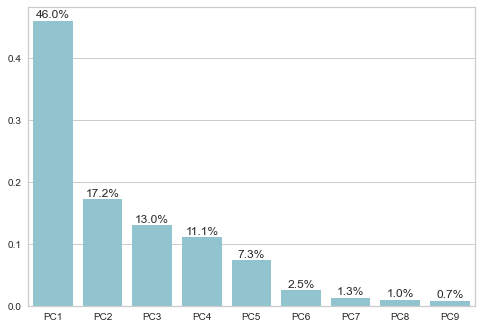

In [836]:
n = pca.n_components_
labels = pc_names
ax = sns.barplot(y = variance, x = labels, color = 'c')

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{round(height*100,1)}%', (x + width/2, y + height + 0.005), ha='center')

As oberved, PC1 accounts for nearly half of the variance of the input data. Therefore, it is a highly informative component and it is important to keep it. In the case way, we can look at the variance provided by the rest of principal components.

In [837]:
cumulative_var = np.cumsum(variance)
cumulative_var

array([0.4595174 , 0.63133365, 0.76137624, 0.87190786, 0.94530998,
       0.97015232, 0.98275663, 0.99256944, 1.        ])

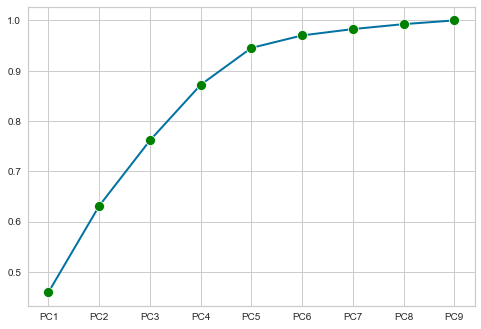

In [838]:
ax = sns.lineplot(x=labels, y=cumulative_var, marker='o', linewidth=2, markersize=10, markerfacecolor='green')

If we look at the cummulative variance, we can see that the first four components already provide signficant information about the data (nearly 87%). Therefore, dimensionality reduction can be done based on these observations and only these four components are considered for further analysis.

In [839]:
data_PCA_filtered = data_PCA.iloc[:,0:4].copy()
data_PCA_filtered.head()

,PC1,PC2,PC3,PC4
0,-2.913025,0.095621,-0.718118,1.005255
1,0.429911,-0.588156,-0.333486,-1.161059
2,-0.285225,-0.455174,1.221505,-0.868115
3,-2.932423,1.695555,1.525044,0.839625
4,1.033576,0.136659,-0.225721,-0.847063


## 3. K-means Clustering <a class="anchor" id="chapter3"></a>

In this section, we are going to focus on clustering with K-means. As we know, we are handling a unsupervised learning problem and therefore we are not provided with the existing targets that we aim to predict. This means that we do not have the target information in advance and thus we need to find it. The way to do this is by identifying groups in the data that share certain attributes. In this case, K-means algorithm is used. 

K-means is based on a two-step process. It firstly creates k centroids (one for each cluster) in the feature-space and assigns each point of the dataset to the nearest cluster. To do so, Euclidean distances are computed. Then, the centroid location is adjusted so that the distance to the assigned points is minimized. This process is repeated until no further adjustements are done to the centroids, that is, they are not moving any more. 

Parameter k, the number of clusters, is crucial as it determines the number of groups we aim to identidy within our data. It is important therefore to find the ideal number of clusters that provide the best classification and representation of our data.  

### 3.1. Elbow Method <a class="anchor" id="section_3_1"></a>

Let's first use the Elbow method to determine the optimum number of clusters. The method is based on calculating the sum of squared distances to the nearest cluster centroid for different number of clusters (k). As k increases, the sum os squared errors decreases. If we plot this variation, it will result in an elbow-shape curve with. In this way, the sum of squared errors rapidly decreases at the begining, which means that better refinement is achieved as the classification based on k groups better characterizes our data. This variation slows down as we keep increasing k, which means no further substantial improvement is obtained. It should be noted that if we keep increasing k, we reach a point where we have the same number of clusters as datapoints, thus the computed sum would be equal to zero. Obviously, we do not intend to reach that point as the objective is to find the minimum number of clusters that better represents a classification of our dataset. Thus, the selection of the optimum k will be done by looking at the minimum number of k for which the variation of the sum of squared errors starts to diminish, which corresponds to the elbow point. To do so, we are going to use the KElbowVisualizer algorithm for k values between 1 and 10:

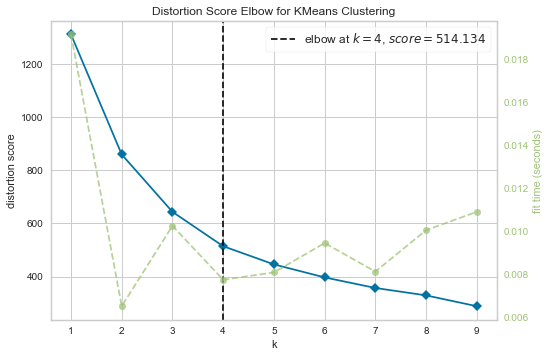

In [840]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(data_PCA_filtered)    
visualizer.poof();

In this case, KElbowVisualizer suggests four clusters. This suggestion is based on the resulting sum of squared errors and the fitting time it takes to classify our data when considering that number of clusters. As observed, higher number of clusters would also imply higher computational cost, which is also important to keep in mind.

### 3.2. Silhouette Coefficient <a class="anchor" id="section_3_2"></a>

We can also look at the Silhouette coefficient, which represents how well individual points are assigned to their clusters. It is computed based on the average distance of each individual point to all points belonging to any other clusters, and the average distance to all points belonging to the same cluster. Ideally, datapoints belonging to the same cluster would be clearly and densely concentrated in a region of the feature-space and well-separated from other clusters. The value of the Silhouette coeficient lies within [-1, 1]. A score of 1 would imply that there is no doubt that the datapoint belongs to the cluster it was assigned to, whereas a score of -1 indicates that the point could have been assigned to the wrong cluster. A value of 0 denote overalapping clusters, meaning that the datapoint lies in the decision boundary between two clusters. Let's therefore look at the average Silhouette score computed obtained for different number of clusters:

For n_clusters = 2 The average Silhouette_score is : 0.32232389389280935
For n_clusters = 3 The average Silhouette_score is : 0.3340859524580049
For n_clusters = 4 The average Silhouette_score is : 0.3519252676725516
For n_clusters = 5 The average Silhouette_score is : 0.28092259771448397
For n_clusters = 6 The average Silhouette_score is : 0.2822148910705012
For n_clusters = 7 The average Silhouette_score is : 0.28640830334329437
For n_clusters = 8 The average Silhouette_score is : 0.2879161317819079
For n_clusters = 9 The average Silhouette_score is : 0.24955572284643218


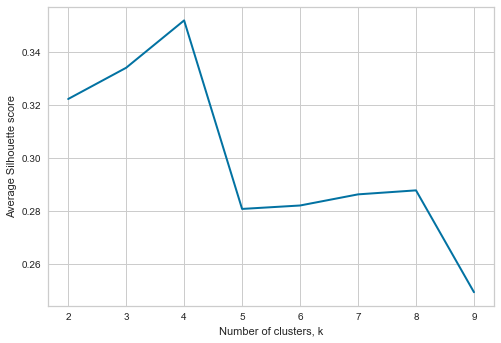

In [841]:
silhouette_list = []
for i in np.arange(2,10):
    clusterer = KMeans(n_clusters=i)
    cluster_labels = clusterer.fit_predict(data_PCA_filtered)
    silhouette_avg = silhouette_score(data_PCA_filtered, cluster_labels)
    silhouette_list.append(silhouette_avg)
    print("For n_clusters =", i, "The average Silhouette_score is :", silhouette_avg)

sns.lineplot(y = silhouette_list, x = np.arange(2,10), linewidth = 2);
plt.xlabel('Number of clusters, k');
plt.ylabel('Average Silhouette score');


Again, we can see that the best score is obtained with four clusters! Nonetheless, these scores do not provide information about how dense the clusters are. Let's now use the SilhouetteVisualizer in order to identify class imbalance. In this way, we can see what portion of the data is assigned to each cluster in order to see if we have a good representation:

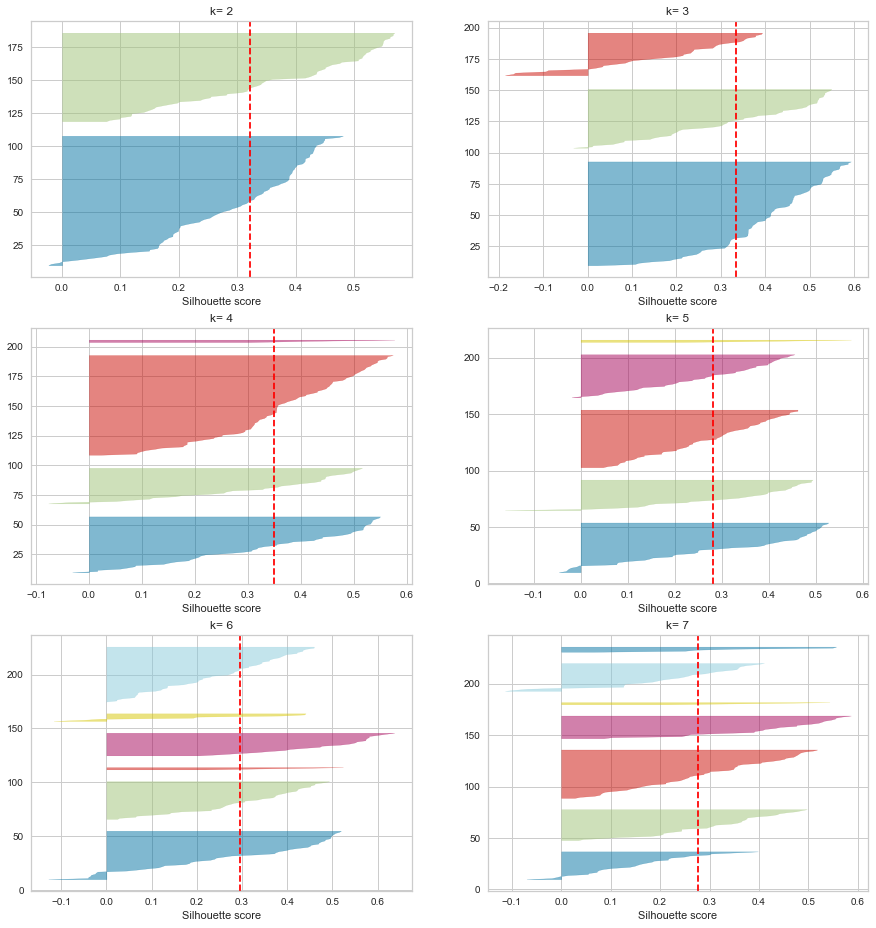

In [842]:
fig,ax = plt.subplots(3,2, figsize = (15,16))
for i in np.arange(2,8):

    km = KMeans(n_clusters=i)
    q, mod = divmod(i,2)

    visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_PCA_filtered)
    visualizer.set_title(f'k= {i}')
    visualizer.ax.set_xlabel('Silhouette score')


Looking at the figures above, we can see that every colored block represents a cluster and the red dotted lines correspond to the average Silhouette score. Therefore, there are as many of these blocks as clusters are in each case. The wider they are, the more datapoins they include. In the first case with k=2, we can see that the majority of the datapoints are assigned to one of the clusters. Ideally, we would like to have a proper balance of the clusters and an even distribution of out datapoints. Therefore, no wide nor narrow blocks are desired. Furthermore, it is also important to keep in mind that we aim to achieve positive scores close to 1. Negative scores would mean that points might be incorrectly assigned and therefore we want to avoid this issue. If we look at the figure obtained with k=4, we can see that the second block from the top is extremely narrow, which means very few points were assigned to this cluster. Condering to add an extra cluster, we can see the first block from the top is splitted in two categories but we still have the same issue with the second one. If we were to keep increasing k, the average score would decrease and more computational time would be needed. We could consider choosing k=3 then, as all the clusters have a noticeable density. Nonetheless, we should keep in mind that there are certain points which might be not properly assigned to one of the groups, as we can deduce from the negative values. Moreover, we can also see that the second cluster will be the largest one.

### 3.3. Computation of Clusters <a class="anchor" id="section_3_3"></a>

Based on the observations previouly discussed, we choose to proceed with three clusters:

In [843]:
clusterer = KMeans(n_clusters=3)
cluster_labels = clusterer.fit_predict(data_PCA_filtered)

We register the computed clusters:

In [844]:
data_PCA_filtered ['cluster'] = cluster_labels
df_data['cluster'] = cluster_labels
df_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1


Let's see how many points (countries) were assigned to each cluster:

In [845]:
df_data['cluster'].value_counts()

1    84
2    48
0    35
Name: cluster, dtype: int64

As expected, cluster 2 is the biggest one. Let's now have a little insight on the characteristics of each cluster by looking at the mean values of our original features:

In [846]:
df_data.groupby('cluster').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster,,,,,,,,,
0,4.897143,58.431429,8.917429,51.508571,45802.857143,2.535000,80.245714,1.741143,43117.142857
1,21.695238,40.484393,6.158333,47.112689,12773.690476,7.608405,72.984524,2.282738,6717.523810
2,91.610417,29.571042,6.433542,43.133333,3897.354167,11.911146,59.239583,4.992083,1909.208333


As observed, cluster 0 is characterised by a huge mortality of 9%, high fertily rate and very low life expectancy of 59 years old. On the other hand, cluster 1 is characterised by low child mortality of 0.4%, low fertility rate and high life expectancy of 80 years old. Additionally, cluster 1 clearly presents the largest income and gdpp as well as the lowest inflation. The highest values for imports and exports are also found in cluster 1, whereas cluster 0 has the lowest numbers. Cluster 2 generally lies somewhere between cluster 0 and cluster 1. 

## 4. Visualization of Results  <a class="anchor" id="chapter4"></a>

Let's now visualize our results! We start by plotting the first two most informative principal components and the assigned clusters:

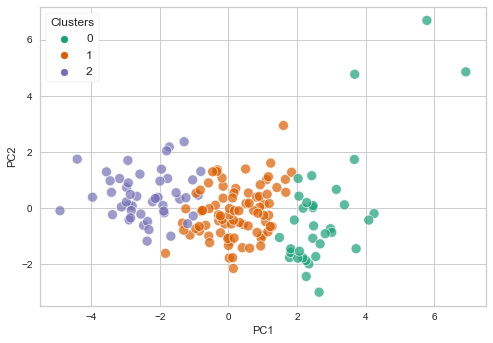

In [847]:
sns.scatterplot(x = data_PCA_filtered['PC1'], y = data_PCA_filtered['PC2'], hue=data_PCA_filtered['cluster'], palette = 'Dark2', alpha=.7, s = 100)
plt.legend(frameon=True, fontsize = 12, title= 'Clusters', framealpha=1);

Looking at the figure above, we can clearly distinguish the areas belonging to each cluster in our feature space. It should be noted that there are few datapoints in the top right corner which were assigned to cluster 1 even though they lie far away. It is now important to remember that, when four clusters were considered, a low-density group was identified, whereas k=3 did have the issue of risk of incorrectly identifying certain points. We could then assume that these points were responsible for these issues.

### 4.1. Geopandas <a class="anchor" id="section_4_1"></a>

For a better visualization of our results, we are going to use geopandas. The latter allows us to access geographical world data which is going to be useful in our case. Let's start by fetching the data:

In [848]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

We now look at the dataset provided by geopandas:

In [849]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


As seen, the dataset includes information about several countries of the globe. We can even plot a map of the Earth's surface:

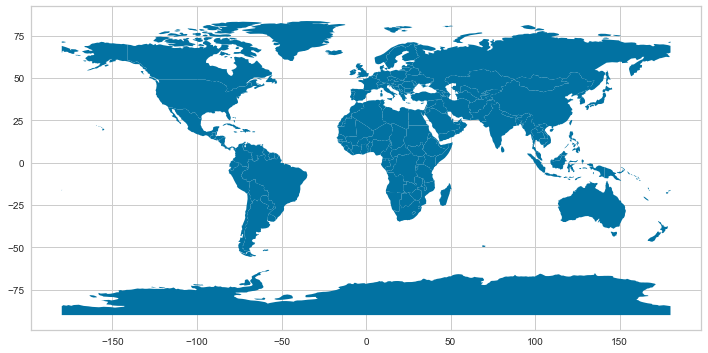

In [850]:
world.plot(figsize=(12, 8));

We now aim to showcase our results in the previous map. To do so, we need to find the countries from our original dataset in the world's dataset we just loaded. Once found, we assign the corresponding cluster so that we can visualize the groups in the world's plot. We create a new column called 'assigned' just to keep track of the countries that could be found in the world's dataset:

In [851]:
world['cluster'] = None

data['cluster'] = df_data['cluster']
data.loc[:,'assigned'] = 'No'

for idx, country in enumerate(world['name']):
    condition = data['country'] == country
    if condition.any():
        world.loc[idx,'cluster'] = data.loc[condition,'cluster'].iloc[0]
        data.loc[data['country'] == country,'assigned'] = 'Yes'

Let's see how many countries remain unassigned:

In [852]:
missing = sum(world['cluster'].isnull())
print(f'Countries not found: {missing}')

Countries not found: 40


It should be noted that not all countries are equally named in both datasets. Therefore, we split every string corresponding to a country name into its components and find the most similar name in the other dataset with the highest number of coincidences based on these components. For example, 'United States of America' is not the same as 'United States' and therefore no perfect match was previously found. However, we can split the components into ['United', 'States', 'of', 'America'] and ['United', 'States'] and compare them. In this case, we can observe two coincidences: 'United' and 'States'. If no other name with more coincidices is found, we assume these two cases correspond to the same country and we assign the corresponding cluster. 

In [853]:
def assign_country(df1, df2, col1, col2, missing_parameter):
    
    list_countries =  list(df1[col1])
    count = 0
    c_dict = {}

    for country_1, idx1 in zip(df2[df2[missing_parameter].isnull()][col2], df2[df2[missing_parameter].isnull()].index):
        c_dict[country_1] = {'Found as:': [], 'Coincidences:': [], f'{missing_parameter.capitalize()}:': []}

        for idx2, country_2 in enumerate(list_countries):
            count = 0

            for word in re.split("[, \-!?:]+",country_1):
                for word_2 in re.split("[, \-!?:]+", country_2):
                    if word in word_2:
                        count = count + 1
            if count:
                c_dict[country_1]['Found as:'].append(country_2)
                c_dict[country_1]['Coincidences:'].append(count)
                c_dict[country_1][f'{missing_parameter.capitalize()}:'].append(df1.loc[idx2,missing_parameter])

        coincidences = c_dict[country_1]['Coincidences:']
        if coincidences:
            max_coincidences = max(coincidences)
            idx_max = coincidences.index(max_coincidences)
            selected_country = c_dict[country_1]['Found as:'][idx_max]
            print(f'{country_1} identified as {selected_country}')

            df1.loc[df1[col1] == selected_country,'assigned'] = 'Yes'

            df2.loc[idx1,missing_parameter] = c_dict[country_1][f'{missing_parameter.capitalize()}:'][idx_max]

In [854]:
assign_country(data, world, 'country', 'name', 'cluster')

United States of America identified as United States
Papua New Guinea identified as Equatorial Guinea
Dem. Rep. Congo identified as Congo, Dem. Rep.
Dominican Rep. identified as Congo, Dem. Rep.
Côte d'Ivoire identified as Cote d'Ivoire
Central African Rep. identified as Central African Republic
Congo identified as Congo, Dem. Rep.
Eq. Guinea identified as Equatorial Guinea
North Korea identified as South Korea
New Caledonia identified as New Zealand
Solomon Is. identified as Solomon Islands
N. Cyprus identified as Cyprus
Bosnia and Herz. identified as Bosnia and Herzegovina
Macedonia identified as Macedonia, FYR
Trinidad and Tobago identified as Antigua and Barbuda
S. Sudan identified as Sudan


As observed, the majority of the reamining countries were properly identified. Nonetheless, some mistakes and wrong identifications were also made. For example, 'North Korea' was identified as 'South Korea' as the latter was the most similar name that could be found. However, we are aware that these are very different countries. Unfortunately, our identifier does not know this. On the other hand, 'S. Sudan' is indeed 'Sudan' so no confusion here. 

Having assessed the decisions made when matching countries, we manually remove the assigned clusters to the countries which we know were not correctly identified:

In [855]:
countries_missasigned_world = ['Dominican Rep.', 'Congo', 'Papua New Guinea', 'North Korea', 'New Caledonia', 'Trinidad and Tobago']
for idx,country_world in enumerate(world.name):
    if country_world in countries_missasigned_world:
        world.loc[idx,'cluster'] = None

In [856]:
countries_missasigned_data = ['South Korea','New Zealand','Antigua and Barbuda']
for idx,country_data in enumerate(data.country):
    if country_data in countries_missasigned_data:
        data.loc[idx,'Assigned'] = 'No'

Let's look at the remaining countries with no cluster:

In [857]:
world[world['cluster'].isnull()].name.sort_values()

159                Antarctica
67                      Congo
47                       Cuba
153                   Czechia
166                  Djibouti
17             Dominican Rep.
165                  Ethiopia
20               Falkland Is.
23     Fr. S. Antarctic Lands
22                  Greenland
36                   Honduras
174                    Kosovo
105                Kyrgyzstan
92                       Laos
27                     Mexico
134             New Caledonia
35                  Nicaragua
95                North Korea
79                  Palestine
7            Papua New Guinea
45                Puerto Rico
152                  Slovakia
12                    Somalia
167                Somaliland
108                     Syria
140                    Taiwan
175       Trinidad and Tobago
2                   W. Sahara
48                   Zimbabwe
73                   eSwatini
Name: name, dtype: object

In the same way, let's look at the countries where no match was found:

In [858]:
data[data.assigned == 'No'].country.sort_values()

11                            Bahrain
13                           Barbados
30                         Cape Verde
36                            Comoros
38                        Congo, Rep.
43                     Czech Republic
45                 Dominican Republic
61                            Grenada
81                           Kiribati
83                    Kyrgyz Republic
84                                Lao
96                           Maldives
98                              Malta
100                         Mauritius
101             Micronesia, Fed. Sts.
127                             Samoa
131                        Seychelles
133                         Singapore
134                   Slovak Republic
141    St. Vincent and the Grenadines
151                             Tonga
Name: country, dtype: object

Considering the previous two sets of unassigned countries, we can find the correct matches and specify them manually:

In [859]:
dict_countries_assign = {'Czenia':'Czech Republic', 'Dominican Rep.':'Dominican Republic','Kyrgyzstan':'Kyrgyz Republic','Lao':'Laos','Slovakia':'Slovak Republic'}

In [860]:
for country_world, country_data in dict_countries_assign.items():
    world.loc[world.name == country_world, 'cluster'] = data.loc[data.country == country_data, 'cluster']
    data.loc[data.country == country_data, 'assigned'] = 'Yes'

Next, we change the cluster type to object as it represents a category.

In [861]:
world.cluster = world.cluster.astype('object')

And the finally plot our results!

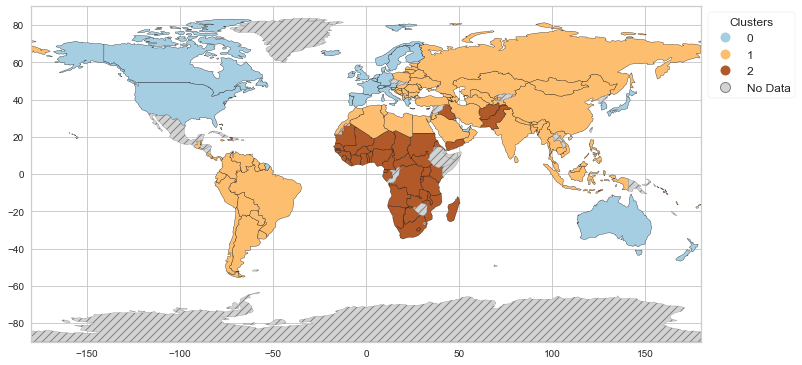

In [862]:
ax = world.plot(figsize=(12, 8), column='cluster', cmap='Paired', k=4, legend=True, edgecolor='black',
                missing_kwds={'color': 'lightgrey', 'label':'No Data', 'hatch': '///', 'edgecolor': 'gray'});

leg = ax.get_legend()
leg.set_frame_on(True)
leg.set_title('Clusters')
leg.set_bbox_to_anchor((1.15, 1.0))
leg.set_alpha(0)
plt.rc('legend', fontsize=12)

plt.ylim([-90, 90]);
plt.xlim([-180, 180]);

The figure above shows a classification of the available countries and the identified clusters. In the first case of cluster 0, it is constituted by South America, North-Africa, a minor portion of Oceania and the majority of Asia. The second group, cluster 1, mainly includes Central and South-Africa and a few Asian countries. In the same way, we notice that Europe, North-America and Australia are assignated to the same group represented by cluster 2. Based on our general knowledge in socioeconomics, we can clearly see that the identified groups indeed correspond to geographic areas with similar degree of development index. Therefore, humanitarian aid should be sent to the countries belonging to cluster 1 followed by countries from cluster 0.

### 4.2. API - Latitude and Longitude <a class="anchor" id="section_4_2"></a>

Unfortunately, not every country for which we computed clusters was found in the world dataset. Therefore, there are certain countries which were not shown in the figure above. Let's see how many countries were left:

In [863]:
missing =  data.loc[data.assigned == 'No',:].shape[0]
print(f'Countries no identified from the original data: {missing}')

Countries no identified from the original data: 17


In order to address this issue, we could look up the location of the countries and then plot them accordingly. To do so, we can use an available API that provides the latitude and the longitude coordinates of several capital cities along with their respective countries. Let's then first make a request to the API:

In [864]:
response = requests.get('http://techslides.com/demos/country-capitals.json')
print(response)

<Response [200]>


It is important to look at the status of the request in order to know if any problem arose. A response of 200 means the request was processed successfully on server.

Next, we load the content of the response taking into account it is in JSON format:

In [865]:
response_json  = response.json()

In [866]:
response_json[:3]

[{'CountryName': 'Somaliland',
  'CapitalName': 'Hargeisa',
  'CapitalLatitude': '9.55',
  'CapitalLongitude': '44.050000',
  'CountryCode': 'NULL',
  'ContinentName': 'Africa'},
 {'CountryName': 'South Georgia and South Sandwich Islands',
  'CapitalName': 'King Edward Point',
  'CapitalLatitude': '-54.283333',
  'CapitalLongitude': '-36.500000',
  'CountryCode': 'GS',
  'ContinentName': 'Antarctica'},
 {'CountryName': 'French Southern and Antarctic Lands',
  'CapitalName': 'Port-aux-FranÃ§ais',
  'CapitalLatitude': '-49.35',
  'CapitalLongitude': '70.216667',
  'CountryCode': 'TF',
  'ContinentName': 'Antarctica'}]

As we can see, the json output we received comes as a list of dictionaries. We now convert it into a dataframe for better handling:

In [867]:
df_response = pd.DataFrame.from_records(response_json)

Let's take a look at the fetched dataframe:

In [868]:
print(f'There are {df_response.shape[0]} countries and {df_response.shape[1]} features')

There are 245 countries and 6 features


In [869]:
df_response.head()

,CountryName,CapitalName,CapitalLatitude,CapitalLongitude,CountryCode,ContinentName
0,Somaliland,Hargeisa,9.55,44.050000,NULL,Africa
1,South Georgia and South Sandwich Islands,King Edward Point,-54.283333,-36.500000,GS,Antarctica
2,French Southern and Antarctic Lands,Port-aux-FranÃ§ais,-49.35,70.216667,TF,Antarctica
3,Palestine,Jerusalem,31.766666666666666,35.233333,PS,Asia
4,Aland Islands,Mariehamn,60.116667,19.900000,AX,Europe


We create two new features for both the latitude and longitude in our original dataset:

In [870]:
data['CapitalLatitude'] = None
data['CapitalLongitude'] = None

Similarly as before, we look for the countries in the response dataset. In this case, once a match is found, we save the coordinates in our original dataset:

In [871]:
for idx, country in enumerate(data['country']):
    condition = df_response['CountryName'] == country
    if condition.any():
        data.loc[idx,'CapitalLatitude'] = df_response.loc[condition,'CapitalLatitude'].iloc[0]
        data.loc[idx,'CapitalLongitude'] = df_response.loc[condition,'CapitalLongitude'].iloc[0]

Let's see again how many countries were not found:

In [872]:
missing = sum(data.CapitalLatitude.isnull())
print(f'Countries no identified from the original data: {missing}')

Countries no identified from the original data: 10


In [873]:
missing_coords = data.CapitalLatitude.isnull()
data[missing_coords]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster,assigned,Assigned,CapitalLatitude,CapitalLongitude
23,Brunei,10.5,67.4,2.84,28.0,80600,16.700,77.1,1.84,35300,0,Yes,NaN,None,None
37,"Congo, Dem. Rep.",116.0,41.1,7.91,49.6,609,20.800,57.5,6.54,334,2,Yes,NaN,None,None
38,"Congo, Rep.",63.9,85.1,2.46,54.7,5190,20.700,60.4,4.95,2740,2,No,NaN,None,None
56,Gambia,80.3,23.8,5.69,42.7,1660,4.300,65.5,5.71,562,2,Yes,NaN,None,None
83,Kyrgyz Republic,29.6,51.6,6.18,81.7,2790,10.000,68.5,3.10,880,1,Yes,NaN,None,None
84,Lao,78.9,35.4,4.47,49.3,3980,9.200,63.8,3.15,1140,2,No,NaN,None,None
92,"Macedonia, FYR",10.4,39.8,7.09,58.1,11400,2.040,74.0,1.47,4540,1,Yes,NaN,None,None
101,"Micronesia, Fed. Sts.",40.0,23.5,14.20,81.0,3340,3.800,65.4,3.46,2860,1,No,NaN,None,None
134,Slovak Republic,7.0,76.3,8.79,77.8,25200,0.485,75.5,1.43,16600,0,Yes,NaN,None,None
141,St. Vincent and the Grenadines,20.7,26.9,4.47,57.1,9920,4.440,71.6,2.07,6230,1,No,NaN,None,None


We then use the function we previously defined in order to match the countries with the highest similarity:

In [874]:
assign_country(df_response, data,'CountryName','country', 'CapitalLatitude')

Brunei identified as Brunei Darussalam
Congo, Dem. Rep. identified as Democratic Republic of the Congo
Congo, Rep. identified as Democratic Republic of the Congo
Gambia identified as The Gambia
Kyrgyz Republic identified as Central African Republic
Lao identified as Laos
Macedonia, FYR identified as Macedonia
Micronesia, Fed. Sts. identified as Federated States of Micronesia
Slovak Republic identified as Central African Republic
St. Vincent and the Grenadines identified as Saint Vincent and the Grenadines


In [875]:
assign_country(df_response, data,'CountryName','country', 'CapitalLongitude')

Brunei identified as Brunei Darussalam
Congo, Dem. Rep. identified as Democratic Republic of the Congo
Congo, Rep. identified as Democratic Republic of the Congo
Gambia identified as The Gambia
Kyrgyz Republic identified as Central African Republic
Lao identified as Laos
Macedonia, FYR identified as Macedonia
Micronesia, Fed. Sts. identified as Federated States of Micronesia
Slovak Republic identified as Central African Republic
St. Vincent and the Grenadines identified as Saint Vincent and the Grenadines


Great! The majority of the countries were properly matched. Only one country, 'Congo, Rep.', was mistakenly assigned. Let's see possible matches that we can find in the response dataframe for this country:

In [876]:
for c in df_response.CountryName:
    if 'Congo' in c:
        print(c)

Democratic Republic of the Congo
Republic of Congo


We can see two possible matches were found for 'Congo, Rep.'. Taking into account that both names have the same similarity with respect to 'Congo, Rep.' the algorithm mistakenly just chooses the first one that appears. However, we know that 'Congo, Rep' actually refers to 'Republic of Congo'. We manually fix this issue:

In [877]:
dict_country = {'Congo, Rep.':'Republic of Congo'}

for c1,c2 in dict_country.items():
    data.loc[data.country == c1,'CapitalLongitude'] = df_response.loc[df_response.CountryName == c2,'CapitalLongitude'].iloc[0]
    data.loc[data.country == c1,'CapitalLatitude'] = df_response.loc[df_response.CountryName == c2,'CapitalLatitude'].iloc[0]

We check again if we have any missing coordinates:

In [878]:
missing_coords = data.CapitalLatitude.isnull()
print(f'Missing coordinates: {data[missing_coords].shape[0]}')

Missing coordinates: 0


Nice! This time we are not missing any country! 

Now let's make sure that all latitude and longitude values consist of numbers:

In [879]:
for idx, coord in enumerate(data.CapitalLatitude):
    if any(w.isalpha() for w in coord):
        print(f'{data.country.loc[idx]} country has non-numerical coords {data.CapitalLatitude.loc[idx]}')

United States country has non-numerical coords  D.C.


In [880]:
for idx, coord in enumerate(df_response.CapitalLongitude):
    if any(w.isalpha() for w in coord):
        print(f'{df_response.CountryName.loc[idx]} country has non-numerical coords {df_response.CapitalLongitude.loc[idx]}')

Oops! We saw that United States does not have valid coordinates. Let's look up the correct coordinates of the United States and fix them: 

In [881]:
data.loc[data.country == 'United States','CapitalLatitude'] = '38.53'
data.loc[data.country == 'United States','CapitalLongitude'] = '-77.03'

Now we change the type of the latitute and longitude features to numerical (float) so that we can plot the values:

In [882]:
data = data.astype({'CapitalLatitude': 'float32'})
data = data.astype({'CapitalLongitude': 'float32'})

Let's finally plot in our world map the resulting clusters for each country at the corresponding capital location:

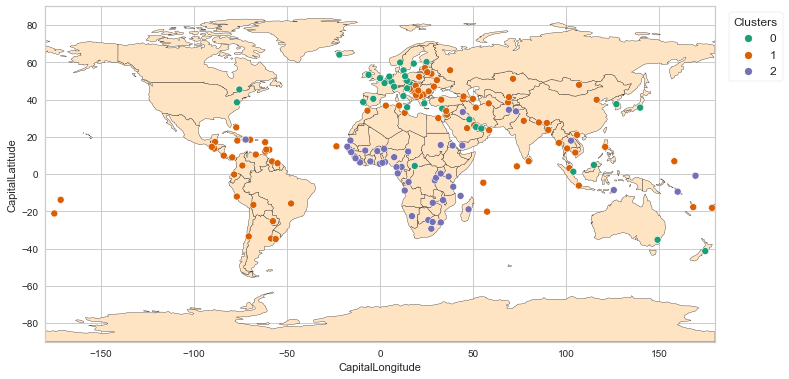

In [883]:
base=world.plot(figsize=(12, 8), color = 'bisque', edgecolor='black')
sns.scatterplot(ax=base,data=data, y='CapitalLatitude', x='CapitalLongitude',hue='cluster', palette = 'Dark2');
plt.legend(frameon=True, fontsize = 12, title= 'Clusters', framealpha=1, bbox_to_anchor=(1.11, 1.0))
plt.ylim([-90, 90]);
plt.xlim([-180, 180]);

Voilà! We are now representing all the clusters we computed for all the provided countries in the original dataset. Looking at the map. we can see the same pattern as before. Most countries in Africa belong to the same group, the same observation is made for European and North-American countries. Additionally, a third group consisting of South-American and the majority of Asian countries was also identified. Therefore, the same conclusions as before can be extracted. Countries belonging to cluster 1, mainly found in Africa, would be the priority in terms of necessity of humanitatian aid. Then, countries belonging to cluster 2 would be the second group of countries where aid should be sent. North-America, Europe, Australia and New Zealand would be the last targets of NGOs.